In [20]:
import requests
import json
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import time
import numpy as np

ID_CATEGORY = 125
ID_SERIES = "GNPCA"
DB = "./database.db"

KEY = "518e72a11de080028921e78aba2a102c"
URL_KEY = "&api_key=" + KEY + "&file_type=json"
URL_BASE = "https://api.stlouisfed.org/fred/"

#costante usata per selezionare il numero di valori da graficare.
#è importante che sia negativa! In quanto sono graficati gli ultimi dati
#è usato anche nel calcolo della varinza tra serie, nel case study
NUMBER_VALUE = -50

In [21]:
#File 'request.py' del rispettivo package

def request_json(url):
    
    try:
        
        request = requests.get(url)
        check = request.status_code
    
        if check != 200: return -1
    
    except requests.ConnectionError: return -1
        
    return request
    
    
def get(url_base, url_key, type, id):
            
    if type == "category_children": url = url_base + "category/children?category_id=" + id + url_key
            
    elif type == "series": url = url_base + "category/series?category_id=" + str(id) + url_key
    
    elif type == "observation": url = url_base + "series/observations?series_id=" + id + url_key
        
    return request_json(url)

#print(json.dumps(r.json(), indent=4))

In [ ]:
#File 'database.py' del rispettivo package

def connect_db(db_file):
    
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        return connection
    
def create_db(db_file):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    #Tabella delle categorie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS categories
       ([id] TEXT PRIMARY KEY, [name] TEXT, [parent_id] TEXT)
       ''')
    
    #Tabella delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    #Tabella con le osservabili delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS observations
       ([date] TEXT, [id] TEXT, [value] TEXT, PRIMARY KEY (date, id))
       ''')
        
    #Tabella con l’elenco delle serie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess_downloaded
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    connection.commit()
    connection.close()

def insert_db(db_file, id, type, update):

    json = get(URL_BASE, URL_KEY, type, id)
    if json == -1:
        
        print("Wrong request!")
        return -1
        
    if type == "category_children":
          
        categories = json.json()["categories"]
        lenght = len(categories)
                
        query_check = ''' SELECT count(*) FROM categories WHERE id = (?) '''
        query_update = ''' UPDATE categories SET name = (?), parent_id = (?) WHERE id = (?) '''
        query = ''' INSERT INTO categories (id, name, parent_id) VALUES (?,?,?) '''
    
    elif type == "observation":
        
        observations = json.json()["observations"]
        lenght = len(observations)
        
        query_check = ''' SELECT count(*) FROM observations WHERE date = (?) AND id = (?) '''
        query_update = ''' UPDATE observations SET value = (?) WHERE date = (?) AND id = (?) '''
        query = ''' INSERT INTO observations (date, id, value) VALUES (?,?,?) '''

    elif type == "series":
        
        series = json.json()["seriess"]
        lenght = len(series)
        
        query_check = ''' SELECT count(*) FROM seriess WHERE id = (?) '''
        query_download = ''' INSERT INTO seriess_downloaded (id, title) VALUES (?,?) ''' 
        query_update = ''' UPDATE seriess SET title = (?) WHERE id = (?) '''
        query = ''' INSERT INTO seriess (id, title) VALUES (?,?) '''
        
    else:
        
        print("Wrong param!")
        return -1
        
    if lenght == 0: return 0
        
    connection = connect_db(db_file)
    cursor = connection.cursor()
        
    for index in range(lenght):
        
        if type == "category_children":
            
            category = categories[index]

            #controlla se (id) è già presente
            params = category["id"],
            cursor.execute(query_check, params)
            check = cursor.fetchone()[0]
    
            #se (id) presente e si vuole aggiornare, allora viene aggiornato il valore
            if check != 0 and update == True:
                
                params = category["name"], category["parent_id"], id
                cursor.execute(query_update, params)
                continue
            
            #se tupla non presente, la si inserisce
            elif check == 0:
                
                params = category["id"], category["name"], category["parent_id"]
                cursor.execute(query, params)
            
        if type == "observation":
        
            observation = observations[index]

            #controlla se (date,id) è già presente
            params = observation["date"], id
            cursor.execute(query_check, params)
            check = cursor.fetchone()[0]
    
            #se (date,id) presente e si vuole aggiornare, allora viene aggiornato il valore
            if check != 0 and update == True:
                
                params = observation["value"], observation["date"], id
                cursor.execute(query_update, params)
                continue
            
            #se tupla non presente, la si inserisce
            elif check == 0:
                
                params = observation["date"], id, observation["value"]
                cursor.execute(query, params)

        elif type == "series":
            
            serie = series[index]
            
            #controlla se id della serie già presente
            params = series[index]["id"],
            cursor.execute(query_check, params)            
            check = cursor.fetchone()[0]

            #se id presente e si vuole aggiornare il dato, si aggionrato la tupla
            if check != 0 and update == True:
                
                params = series[index]["title"], series[index]["id"]
                cursor.execute(query_update, params)
                continue
             
            #se tupla non presente, la si inserisce
            elif check == 0:

                params = series[index]["id"], series[index]["title"]
                cursor.execute(query, params)
                cursor.execute(query_download, params)
                        
        connection.commit()
             
    connection.close()

def get_db(db_file, type, id):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "category_children":
        
        cursor.execute(''' SELECT c.id, c.name, c.parent_id FROM categories c ORDER BY c.parent_id ASC ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','name','parent_id'])

    elif type == "seriess":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
        
    elif type == "seriess_downloaded":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess_downloaded s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
    
    elif type == "observations":
        
        if id is None:
        
            cursor.execute(''' SELECT o.date, o.id, o.value FROM observations o ''')
            
        else:
            
            query = ''' SELECT o.date, o.id, o.value FROM observations o WHERE o.id = (?) '''
            params = id,
            cursor.execute(query, params)
            
        df = pd.DataFrame(cursor.fetchall(), columns=['date', 'id', 'value'])

    else:
        
        connection.close()
        print("Wrong param!")
        return -1
    
    connection.close()
    return df

def download_insert_tree_category(db_file, id, type, update, array):
    
    time.sleep(.5)
    ret = insert_db(db_file, id, type, update)
    
    #si è giunti fino alle foglie dell'albero, quindi si ritorna
    if ret == 0: return array

    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    #si selezionano tutti gli id, dei figli appena scaricati        
    query = ''' SELECT c.id FROM categories c WHERE c.parent_id = (?) '''
    params = id,
    cursor.execute(query, params)
    df = pd.DataFrame(cursor.fetchall(), columns=['id'])
    
    for index in range(len(df)):
              
        value = df.iloc[index]['id']
        array.append(value)
        array = download_insert_tree_category(db_file, value, "category_children", False, array)
    
    connection.close()
    return array
    
#create_db(DB)

#insert_db(DB, ID_CATEGORY, "series", False)

#insert_db(DB, ID_SERIES, "observation", False)

tree = download_insert_tree_category(DB, "0", "category_children", False, [])
print(tree)

#df = get_db(DB, "seriess_downloaded", None)
#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3,
   #                    ):
    #print(df)
    
#df = get_db(DB, "observations", None)
#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3,
   #                    ):
    #print(df)
    
#df = get_db(DB, "category_children", None)
#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3,
   #                    ):
    #print(df)

#df = get_db(DB, "seriess", None)
#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3,
   #                    ):
    #print(df)

In [33]:
#File 'display.py' del rispettivo package

grid_color = "grey"
label_color = "white"
plot_color="green"
title_fontsize = 30
axes_fontsize = 20
text_pad = 20
context = {'axes.edgecolor':'grey',
           'axes.facecolor':'black',
           'font.family':'sans-serif', 
           'figure.facecolor':'black', 
           'figure.edgecolor':'black',
           'xtick.color':'white', 
           'ytick.color':'white', 
           'savefig.transparent':'True'}

def convert_string_float(array_string):
    
    array_float = []
    
    for values in array_string:
    
        if values == ".": values = 0
    
        array_float.append(float(values))
    
    return array_float

def display(x, y, title, id, x_label):

    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.title(title, color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)
        
        if y is not None: plt.plot(x[NUMBER_VALUE:], y[NUMBER_VALUE:], color="green", label="ID: " + id)
        else: plt.plot(x[NUMBER_VALUE:], color="green", label="ID: " + id)
            
        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel(x_label, color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
        
        return plt        
    
def display_observation(id):
    
    pd = get_db(DB, "observations", id)
    x = pd['date'].tolist()
    y = pd['value'].tolist()
    y = convert_string_float(y)    
    
    return display(x, y, "Observation", id, "date")
        
def moving_average(input_array, day):
    
    list = convert_string_float(input_array)
    
    ret = []
    window = 0
    
    for i in range(day):
        window += list[i]
        
    for i in range(day, len(list)):
        ret.append(window / day)
        window = window + list[i] - list[i-day]
    
    return ret
    
def display_moving_average(id, day):
    
    pd = get_db(DB, "observations", id)
    x = pd['value'].tolist()    
    ma = moving_average(x, day)
    
    return display(ma, None, "Moving Average", id, "day")
    
#plt = display_observation(ID_SERIES)
#plt.show()
#plt = display_moving_average(ID_SERIES, 7)
#plt.show()

              id                                              title
0        DEXBZUS  Brazilian Reals to U.S. Dollar Spot Exchange Rate
1        DEXCAUS  Canadian Dollars to U.S. Dollar Spot Exchange ...
2        DEXCHUS  Chinese Yuan Renminbi to U.S. Dollar Spot Exch...
3        DEXDNUS    Danish Kroner to U.S. Dollar Spot Exchange Rate
4        DEXHKUS  Hong Kong Dollars to U.S. Dollar Spot Exchange...
5        DEXINUS    Indian Rupees to U.S. Dollar Spot Exchange Rate
6        DEXJPUS     Japanese Yen to U.S. Dollar Spot Exchange Rate
7        DEXKOUS  South Korean Won to U.S. Dollar Spot Exchange ...
8        DEXMAUS  Malaysian Ringgit to U.S. Dollar Spot Exchange...
9        DEXMXUS    Mexican Pesos to U.S. Dollar Spot Exchange Rate
10       DEXNOUS  Norwegian Kroner to U.S. Dollar Spot Exchange ...
11       DEXSDUS   Swedish Kronor to U.S. Dollar Spot Exchange Rate
12       DEXSFUS  South African Rand to U.S. Dollar Spot Exchang...
13       DEXSIUS  Singapore Dollars to U.S. Doll

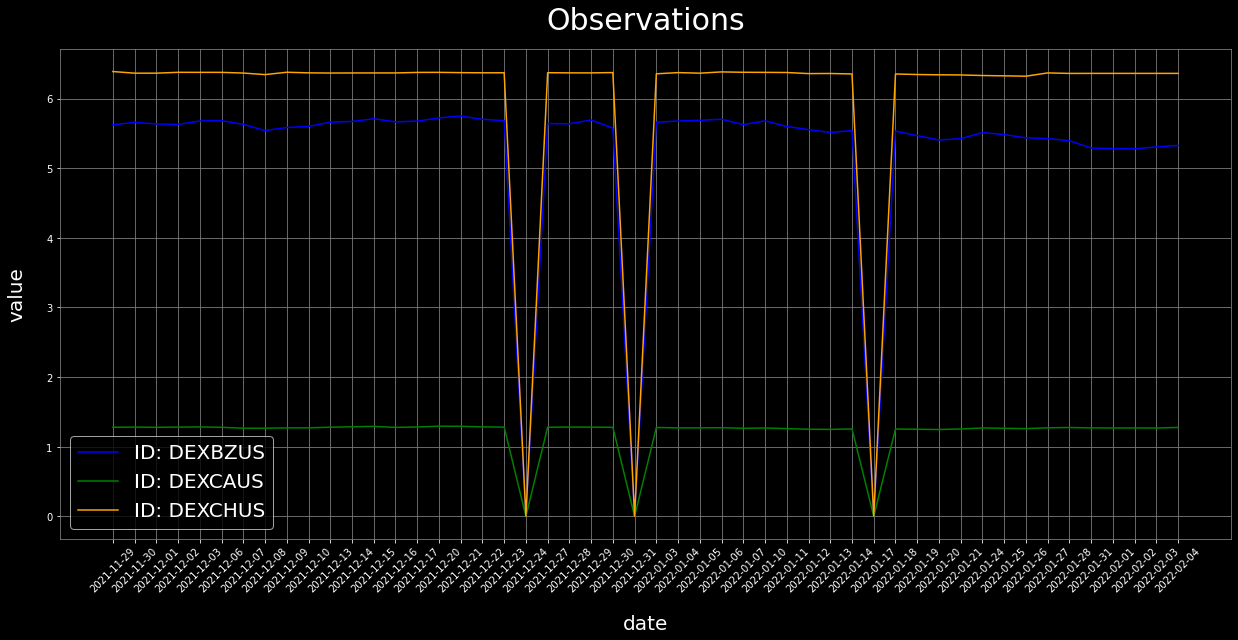

Cov(DEXBZUS,DEXCAUS) = 0.4084642043755101
Cov(DEXCHUS,DEXCAUS) = 0.4657632687510204
Cov(DEXBZUS,DEXCHUS) = 2.0409034571714284


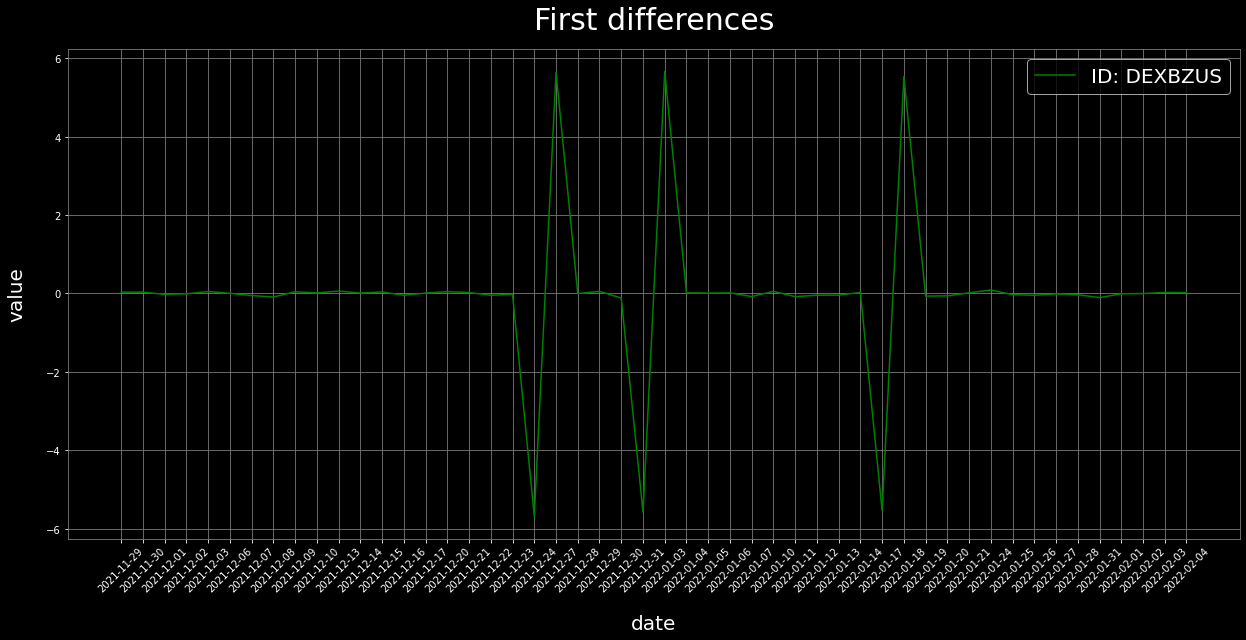

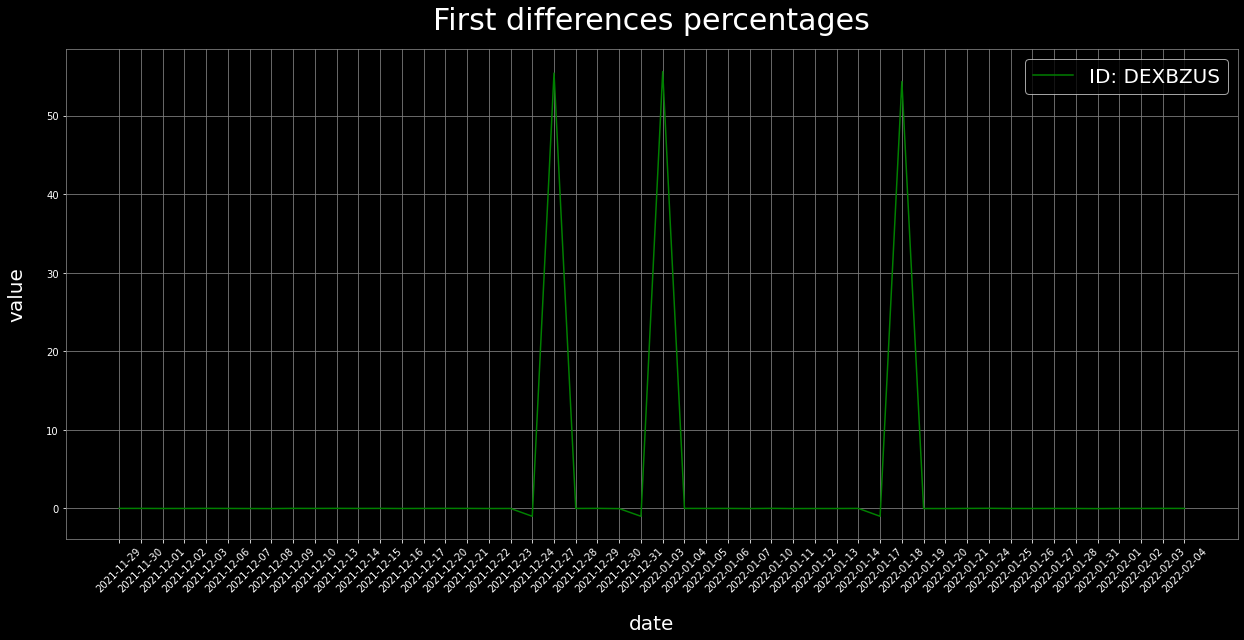

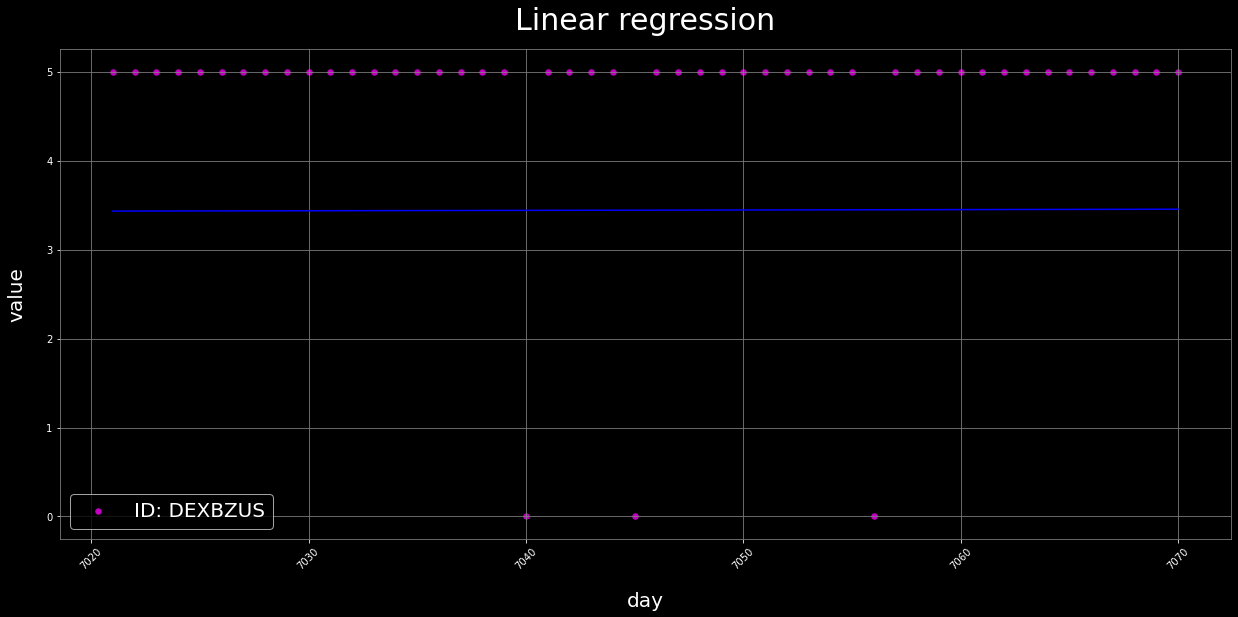

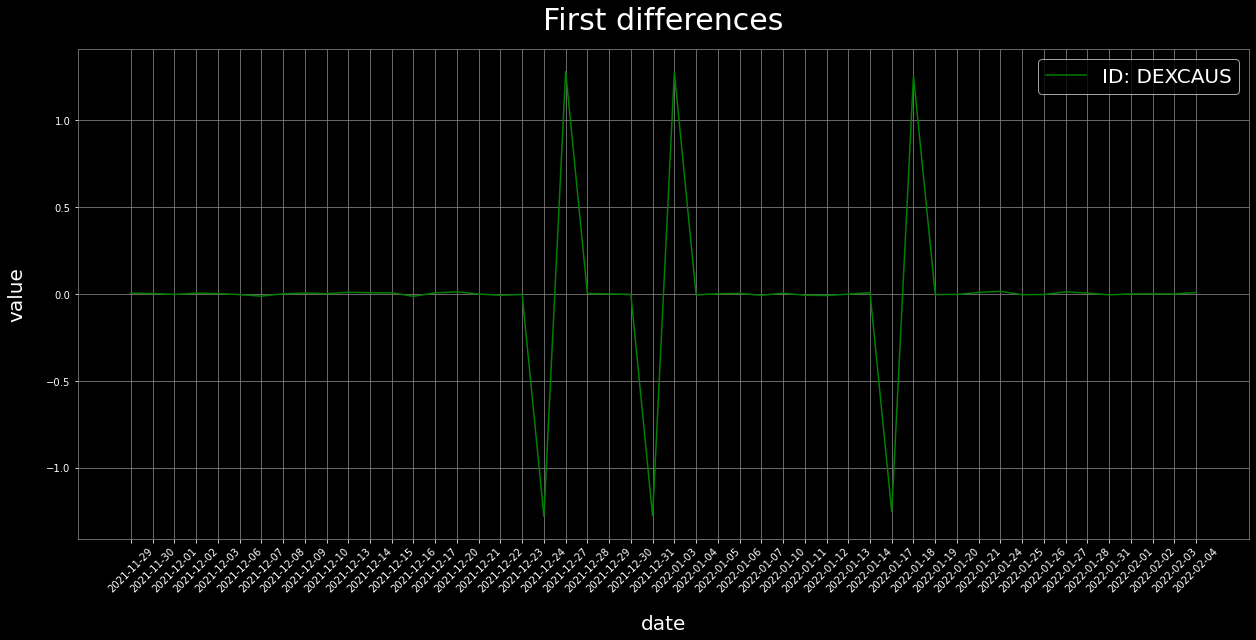

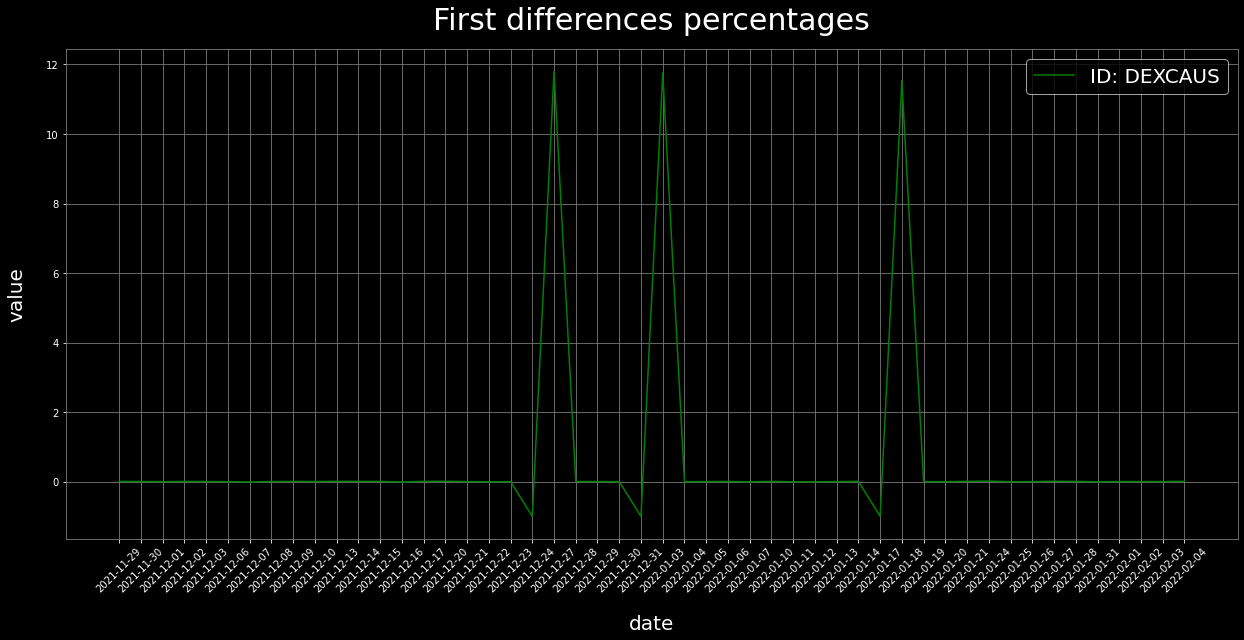

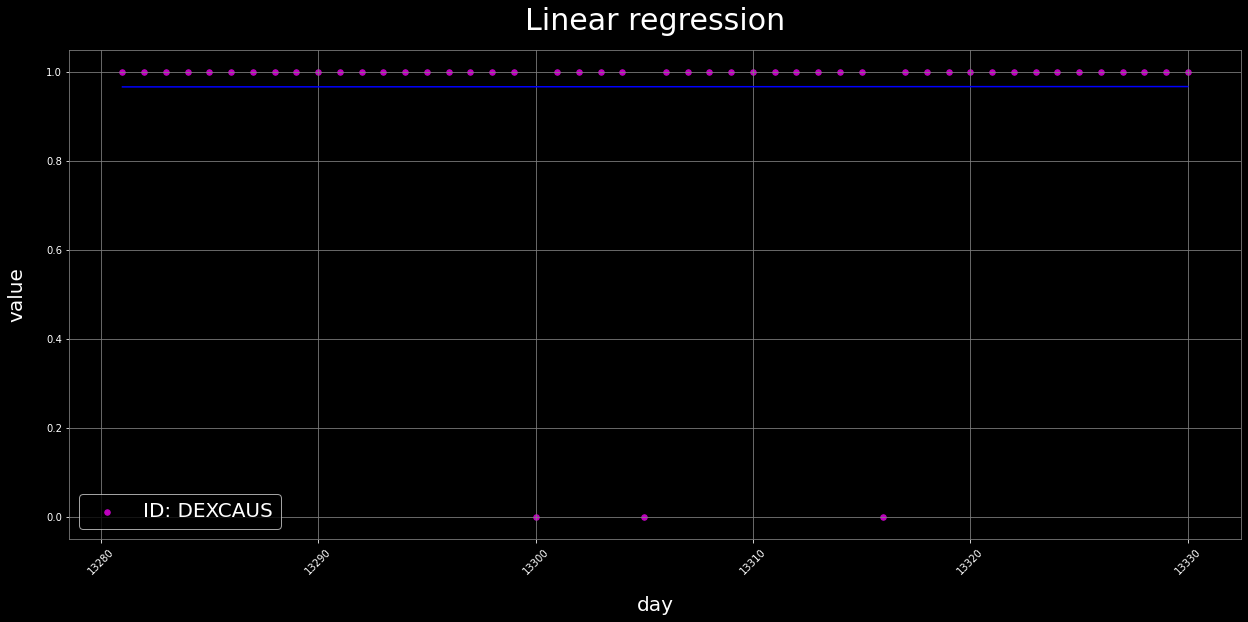

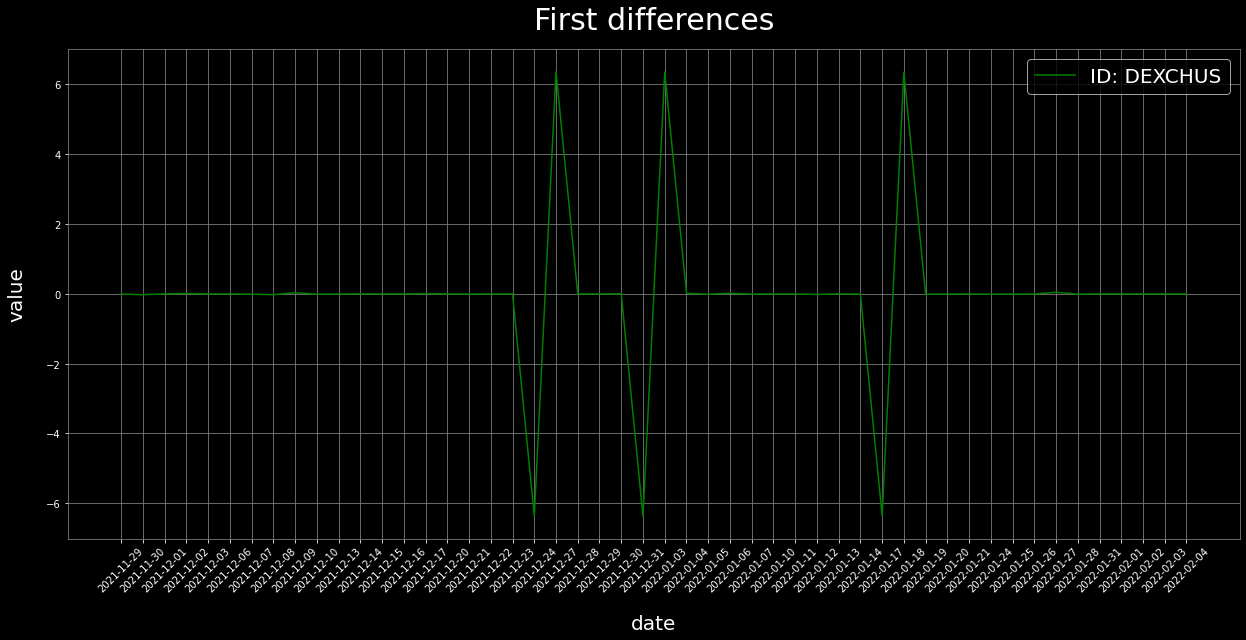

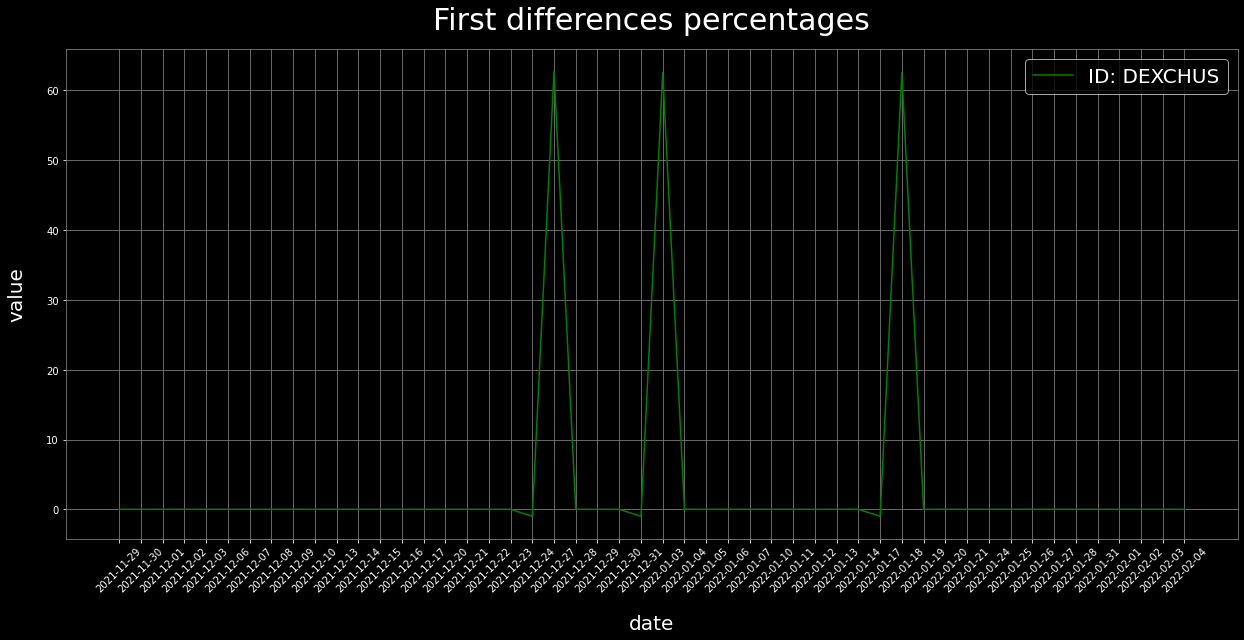

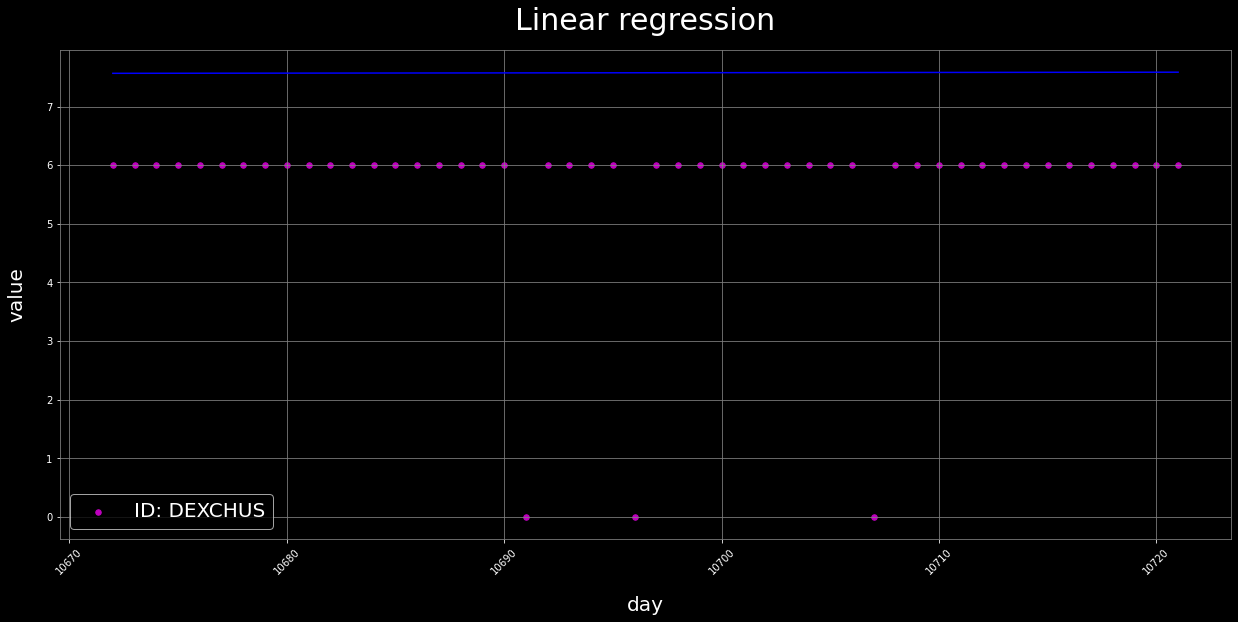

In [26]:
#File 'user.py' del rispettivo package

ID_CATEGORY = 94 #Daily Rates
ID_SERIES_ARRAY = ["DEXBZUS", "DEXCAUS", "DEXCHUS"]

def get_observations(list_series):

    if isinstance(list_series, list) and len(list_series) == 3:

        df = get_db(DB, "observations", list_series[0])
        observations_1 = df['date'].tolist()

        observations_2 = df['value'].tolist()
        observations_2 = convert_string_float(observations_2)

        df = get_db(DB, "observations", list_series[1])
        observations_3 = df['value'].tolist()
        observations_3 = convert_string_float(observations_3)

        df = get_db(DB, "observations", list_series[2])
        observations_4 = df['value'].tolist()
        observations_4 = convert_string_float(observations_4)

        return (observations_1, observations_2, observations_3, observations_4)
    
    else:
        
        df = get_db(DB, "observations", list_series)
        observations_1 = df['date'].tolist()
        observations_2 = df['value'].tolist()
        observations_2 = convert_string_float(observations_2)
        
        return (observations_1, observations_2)
        
def display_observations(list_series):
    
    observations = get_observations(list_series)

    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.title("Observations", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)
        
        plt.plot(observations[0][NUMBER_VALUE:], observations[1][NUMBER_VALUE:], color="blue", label="ID: " + list_series[0])
        plt.plot(observations[0][NUMBER_VALUE:], observations[2][NUMBER_VALUE:], color="green", label="ID: " + list_series[1])
        plt.plot(observations[0][NUMBER_VALUE:], observations[3][NUMBER_VALUE:], color="orange", label="ID: " + list_series[2])
    
        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("date", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
    
        return plt
    
#Calcolare la covarianza
def covariance(list_series):
    
    observations = get_observations(list_series)
    
    covariance = np.cov(observations[1][NUMBER_VALUE:], observations[2][NUMBER_VALUE:])[0][1]
    print("Cov(" + list_series[0] + "," + list_series[1] + ") = " + str(covariance))
    
    covariance = np.cov(observations[3][NUMBER_VALUE:], observations[2][NUMBER_VALUE:])[0][1]
    print("Cov(" + list_series[2] + "," + list_series[1] + ") = " + str(covariance))
    
    covariance = np.cov(observations[1][NUMBER_VALUE:], observations[3][NUMBER_VALUE:])[0][1]
    print("Cov(" + list_series[0] + "," + list_series[2] + ") = " + str(covariance))
    
#Calcolare e graficare su un solo grafico per ogni serie
#la serie delle differenze prime (𝑠𝑖+1 −𝑠𝑖) 
def display_first_diff(id):
    
    observations = get_observations(id)
    
    difference_array = []
    for index in range(len(observations[1]) - 1):
        
        difference = observations[1][index + 1] - observations[1][index]
        difference_array.append(difference)
    
    return display(observations[0], difference_array, "First differences", id, "date")

#Calcolare e graficare su un solo grafico per ogni serie la serie delle 
#differenze prime percentuali 𝑠𝑖+1−𝑠𝑖. (fate attenzione agli ∞)
def display_first_diff_perc(id):

    observations = get_observations(id)
    
    ratio_array = []
    for index in range(len(observations[1]) - 1):
        
        if observations[1][index] == 0: observations[1][index] = 0.1
        difference = (observations[1][index + 1] - observations[1][index])/observations[1][index]
        ratio_array.append(difference)
    
    return display(observations[0], ratio_array, "First differences percentages", id, "date")

def estimate_coef(x, y):
    
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)
    
#Per ogni serie calcolare la retta di regressione
def display_linear_regression(id):
        
    df = get_db(DB, "observations", id)
    
    #converte la sequenza di float in int
    for index in range(len(df)):
        value = df['value'][index]
        if value == ".": 
            df.iat[index, 2] = 0
 
    df['value'] = pd.to_numeric(df['value']).astype(int)
    df['day'] = range(1, len(df) + 1)
    
    b = estimate_coef(df['day'], df['value'])
            
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.title("Linear regression", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)
        
        plt.scatter(df['day'].tolist()[NUMBER_VALUE:], df['value'].tolist()[NUMBER_VALUE:], color = "m", marker = "o", s = 30, label="ID: " + id)

        # predicted response vector
        y_pred = b[0] + b[1]*df['day']

        # plotting the regression line
        plt.plot(df['day'].tolist()[NUMBER_VALUE:], y_pred.tolist()[NUMBER_VALUE:], color = "b")

        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("day", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
    
        return plt
    
#Scaricare  tutte le serie  da  una  singola categoria (in realtà ne sono sufficienti 3)
#potrebbe essere necessario creare un db, con create_db(DB)
insert_db(DB, ID_CATEGORY, "series", False)

#Per vedere tutte le seriess scaricate, e quindi anche quelle relative a Daily Rates:
#df = get_db(DB, "seriess", None)

#Scaricare tutte le osservabili per 3 seriess scelte
for index in range(len(ID_SERIES_ARRAY)):
    insert_db(DB, ID_SERIES_ARRAY[index], "observation", False)

#Graficare le 3 serie su un solo grafico 
plt = display_observations(ID_SERIES_ARRAY)
plt.show()

#Calcolare la covarianza (attenzione ai nan!) 
covariance(ID_SERIES_ARRAY)

#Serie delle differenze prime, differenze prime percentuali e retta di regressione
for index in range(len(ID_SERIES_ARRAY)):
    plt = display_first_diff(ID_SERIES_ARRAY[index])
    plt.show()
    plt = display_first_diff_perc(ID_SERIES_ARRAY[index])
    plt.show()
    plt = display_linear_regression(ID_SERIES_ARRAY[index])
    plt.show()

#display_linear_regression(ID_SERIES)